# Self-Driving Car Engineer Nanodegree


## Building a Traffic Sign Recognition Classifier

In [120]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pandas.io.parsers import read_csv
import tensorflow as tf
from   sklearn.utils import shuffle
from   tensorflow.contrib.layers import flatten
import cv2
import timeit

# Visualizations will be shown in the notebook.
%matplotlib inline
np.random.seed(3)


## Loading the data

In [121]:
# Load pickled data

# TODO: Fill this in based on where you saved the training and testing data

training_file   = "traffic-signs-data/train.p"
validation_file ="traffic-signs-data/valid.p"
testing_file    = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
x_train, y_train = train['features'], train['labels']
x_valid, y_valid = valid['features'], valid['labels']
x_test, y_test   = test['features'],  test['labels']

# Shuffle the training set before going any further
x_train, y_train = shuffle(x_train, y_train)

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Basic Summary of the Data Set

In [122]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = x_train.shape[0]

# TODO: Number of validation examples
n_validation = x_valid.shape[0]

# TODO: Number of testing examples.
n_test = x_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = x_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
unique_classes, class_counts = np.unique(y_train, return_counts=True)
n_classes = unique_classes.size

# Read the traffic sign names
signNames = read_csv("signnames.csv").values[:, 1]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

Sign 6: End of speed limit (80km/h)


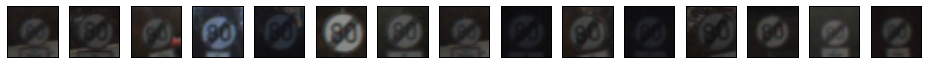

Sign 0: Speed limit (20km/h)


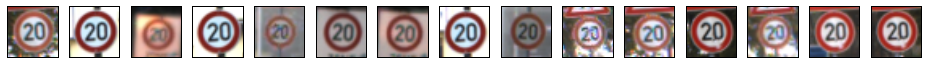

Sign 35: Ahead only


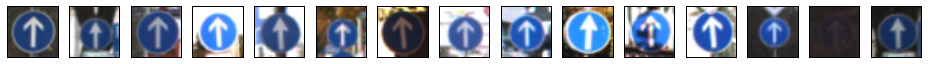

Sign 9: No passing


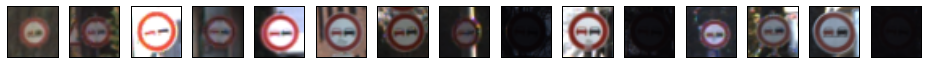

Sign 5: Speed limit (80km/h)


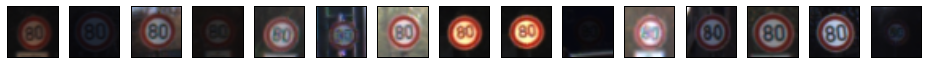

Sign 40: Roundabout mandatory


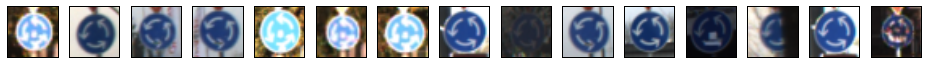

Sign 38: Keep right


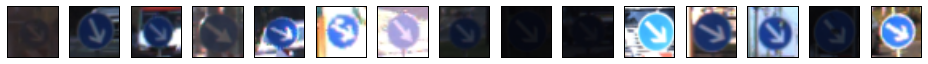

Sign 39: Keep left


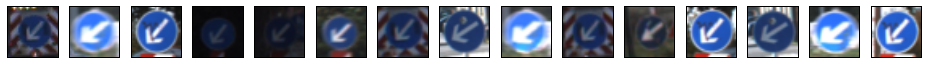

Sign 9: No passing


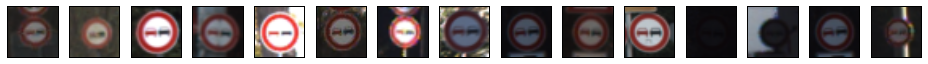

Sign 19: Dangerous curve to the left


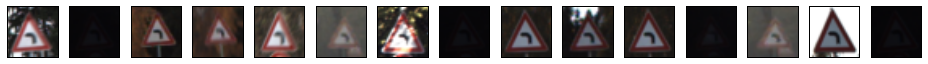

In [161]:
# Chose 10 random classes. Print 15 random images from each class

def showRandomImagesFromDataset(x, y, numClassesToShow, numImgsPerClass, names):

    classesToShow = np.random.randint(low=0, high=n_classes, size=numClassesToShow)

    for sign in classesToShow:
        #Get images for this sign
        print("Sign %i: %s" % (sign, names[sign]))
        imgsSign = x[y==sign]
        #choose 10 random signs
        imgsSign = imgsSign[np.random.randint(low=0, high=imgsSign.shape[0], size=numImgsPerClass), :,:,:]
        fig = plt.figure(figsize = (13, 1))
        for i in range(numImgsPerClass):
            plt.subplot(1, numImgsPerClass, i+1)
            plt.imshow(imgsSign[i,:,:,:])
            plt.xticks([])
            plt.yticks([])
        fig.tight_layout()
        plt.show()
        

showRandomImagesFromDataset(x_train, y_train, numClassesToShow=10, numImgsPerClass=15, names=signNames)
        

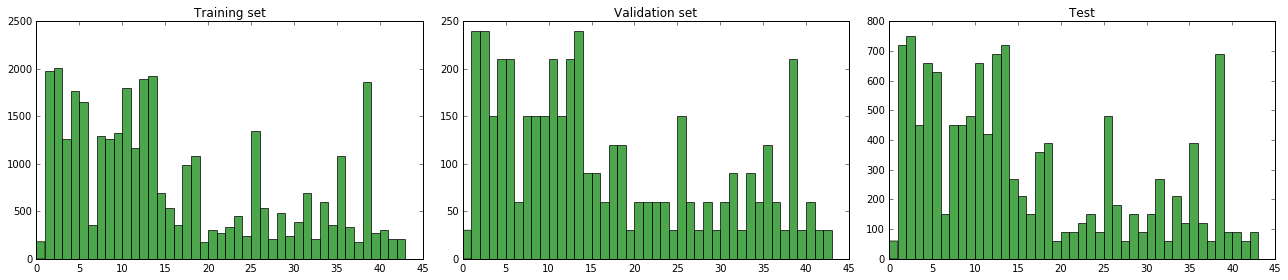

In [124]:
#Distributions of the training, validation and the test sets

yData = [y_train, y_valid, y_test]
compFig = plt.figure(figsize=(18, 4))
for i in range(3):
    ax = plt.subplot(1, 3, i+1)
    ax.set_title(["Training set", "Validation set", "Test"][i])
    plt.hist(yData[i], bins=np.arange(yData[i].min(), yData[i].max()+2), color="green", alpha=0.7)

compFig.tight_layout()
plt.show()

We see that, at least with respect to the number of images per class, the training, validation and the test set have been drawn from the same distribution. However, there is a big variation in the number of images in each class. There are very few images of certain classes and this could potentially lead to low classification accuracy for those. To mitigate this, we will try data augmentation - specially for classes that are under-represented.

### Data augmentation

In attempt to balance our dataset and (as we shall see later) to reduce overfitting, we will augment the dataset. New images will be created from existing images by randomly applying one or more of the following image transforms
- Translation
- Rotation
- Crop + resize
- Perspective
- Gaussion blur
- Additive noise
- Brightness changes

Although more transformations like flips and shear are possible and frequently used, we will not use them here because we will not physically encounter such images. For example, one would never encounter a flipped road sign. Or no physical phenomenon would cause images to get sheared (except perhaps rolling shutter artifacts but that would be relatively rare). 

Since there are already great libraries that perform data augmentation for us, we will use them instead for attempting to write our own. 

In [181]:


from imgaug import augmenters as iaa

# Specify the augmentation pipeline
seq = iaa.Sequential([
    iaa.Crop(px=(0, 5)), # crop images from each side by 0 to 16px (randomly chosen)
    #iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 0.5)) # blur images with a sigma of 0 to 3.0
])


def augmentClass(imgs, labels, ratio, sequence):
    # augment data
    augmented = np.repeat(imgs, repeats=ratio, axis=0)
    augmented = sequence.augment_images(augmented)
    
    #augment labels
    labels = np.repeat(labels, repeats=ratio, axis=0)
    return augmented, labels
    

# Test. Augment a paricular class
i = 36
x_aug, y_aug = augmentClass(x_train[(y_train==i), :,:,:], y_train[y_train==i], ratio=2, sequence=seq)
    
print(np.count_nonzero(y_train==i))
print(x_aug.shape, y_aug.shape)
print(np.max(y_aug), np.min(y_aug))

def showRandomAugmentedImages(x, y, numClassesToShow, numImgsPerClass, names):

    classesToShow = np.random.randint(low=0, high=n_classes, size=numClassesToShow)

    for sign in classesToShow:
        #Get images for this sign
        print("Sign %i: %s" % (sign, names[sign]))
        imgsSign = x[y==sign]
        #choose 10 random signs
        imgsSign = imgsSign[np.random.randint(low=0, high=imgsSign.shape[0], size=numImgsPerClass), :,:,:]
        fig = plt.figure(figsize = (13, 1))
        for i in range(numImgsPerClass):
            plt.subplot(1, numImgsPerClass, i+1)
            plt.imshow(imgsSign[i,:,:,:])
            plt.xticks([])
            plt.yticks([])
        fig.tight_layout()
        plt.show()


#plt.imshow(x_aug[11,:,:,:])
        
#fig = plt.figure(figsize = (8, 20))
#for i in range(20):
#    plt.subplot(10, 2, i+1)
#    plt.imshow(x_aug[i,:,:,:])
#    plt.xticks([])
#    plt.yticks([])
#fig.tight_layout()
#plt.show()

    
    

330
(660, 32, 32, 3) (660,)
36 36


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [15]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

#with open('preproc-data/data.pkl', 'wb') as f:  
#    pickle.dump([x_train, y_train, x_valid, y_valid, x_test, y_test], f)

#with open('objs.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
#    x_train, y_train, x_valid, y_valid, x_test, y_test = pickle.load(f)

#def toGrayscale(imgStack):
#    stackShape = imgStack.shape
#    grayStack = np.zeros((*stackShape[0:3], 1))
#    for img in range(stackShape[0]):
#        grayStack[img, :,:,:] = cv2.cvtColor(imgStack[img, :,:,:], cv2.COLOR_RGB2GRAY)
#    print(grayStack.shape)

def toGrayscale(imgStack):
    # Weights for grayscale conversion taken from 
    # https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html
    # Doing it this way because it allows for a nice vectorized implementation
    grayStack = np.average(imgStack, axis=3, weights=[0.299,0.587, 0.114])
    grayStack = np.reshape(grayStack, (*grayStack.shape, 1))
    return grayStack

    

def Normalize(imgStack, min=0.1, max=0.9):
    dims = imgStack.shape
    vec = np.reshape(imgStack, [dims[0], -1])
    vecmax = np.max(vec, axis=1, keepdims=True)
    vecmin = np.min(vec, axis=1, keepdims=True)
    normed = min + (vec - vecmin)/(vecmax - vecmin)*(max - min)
    return np.reshape(normed, [-1, *dims[1:4]])


if x_train.shape[3] == 3: #Preprocess only if not done before
    # Conver to grayscale
    x_train, x_valid, x_test = [toGrayscale(x)  for x in [x_train, x_valid, x_test]]

    # Normalize all images to between -0.5 and 0.5
    x_train, x_valid, x_test = [Normalize(x, 0.1, 0.9) for x in [x_train, x_valid, x_test]]


#print(x_train.shape)

### Model Architecture

In [16]:
def weight_variable(shape):
    """Create a weight variable with appropriate initialization."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    """Create a bias variable with appropriate initialization."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)


def fc_layer(input_tensor, input_dim, output_dim, layer_name, activation=tf.nn.relu):
    """Reusable code for making a simple neural net layer.
    It does a matrix multiply, bias add, and then uses ReLU to nonlinearize.
    It also sets up name scoping so that the resultant graph is easy to read,
    and adds a number of summary ops.
    """
    with tf.name_scope(layer_name):
        # This Variable will hold the state of the weights for the layer
        with tf.name_scope('weights'):
            weights = weight_variable([input_dim, output_dim])
            #variable_summaries(weights)
        with tf.name_scope('biases'):
            biases = bias_variable([output_dim])
            #variable_++summaries(biases)
        with tf.name_scope('Wx_plus_b'):
            preactivate = tf.matmul(input_tensor, weights) + biases
            #tf.summary.histogram('pre_activations', preactivate)
        act = activation(preactivate, name='activation')
        tf.summary.histogram('activations', act)
        return act, weights

def conv_layer(input, input_dim, output_dim, layer_name, kernel_size, stride):
    with tf.name_scope(layer_name):
        with tf.name_scope('weights'):
            weights = weight_variable([kernel_size, kernel_size, input_dim, output_dim])
            #variable_summaries(weights)
        with tf.name_scope('biases'):
            biases = bias_variable([output_dim])
            #variable_summaries(biases)
        with tf.name_scope('conv'):
            conv = tf.nn.conv2d(input, weights, strides=[1, stride, stride, 1], padding='VALID')
            #variable_summaries(conv)        
        act = tf.nn.relu(conv + biases)
        #tf.summary.histogram('activations', act)
        return tf.nn.max_pool(act, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
        
    
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    #W1 = tf.Variable(tf.truncated_normal([5,5,3,6], mean=mu, stddev=sigma))
    #b1 = tf.Variable(tf.zeros(6))
    #Z1 = tf.nn.conv2d(x, W1, strides=[1,1,1,1], padding='VALID') + b1   
    # TODO: Activation.
    #A1 = tf.nn.relu(Z1)    
    #C1 = tf.layers.conv2d(inputs=x, 
    #                      filters=6,
    #                      kernel_size=[5,5], strides=1, padding='VALID', 
    #                     activation=tf.nn.relu)
    
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    # P1 = tf.nn.max_pool(A1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    #P1 = tf.layers.max_pooling2d(inputs=C1, 
    #                             pool_size=[2,2], strides=2, padding='VALID')

    P1 = conv_layer(x, input_dim=1, output_dim=6, layer_name="CONV1", kernel_size=5, stride=1)
    
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    #W2 = tf.Variable(tf.truncated_normal([5,5,6,16], mean=mu, stddev=sigma))
    #b2 = tf.Variable(tf.zeros(16))
    #Z2 = tf.nn.conv2d(P1, W2, strides=[1,1,1,1], padding='VALID') + b2
    #C2 = tf.layers.conv2d(inputs=P1, filters=16, 
    #                      kernel_size=[5,5], strides=1, padding='VALID', 
    #                      activation=tf.nn.relu)
    # TODO: Activation.
    #A2 = tf.nn.relu(Z2)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    #P2 = tf.nn.max_pool(A2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    #P2 = tf.layers.max_pooling2d(inputs=C2, 
    #                             pool_size=[2,2], strides=2, padding='VALID')

    P2 = conv_layer(P1, input_dim=6, output_dim=16, layer_name="CONV2", kernel_size=5, stride=1)
    
    # TODO: Flatten. Input = 5x5x16. Output = 400.
    P2 = tf.contrib.layers.flatten(P2)
    
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    #W3 = tf.Variable(tf.truncated_normal([400,120], mean=mu, stddev=sigma))
    #b3 = tf.Variable(tf.zeros(120))
    #Z3 = tf.matmul(P2, W3) + b3
    #D3 = tf.nn.dropout(Z3, keep_prob=0.6)        
    
    # TODO: Activation.
    #A3 = tf.nn.relu(Z3)
    #F3 = tf.layers.dense(inputs=P2, units=300, activation=tf.nn.relu) # was 120
    F3, W3 = fc_layer(P2, input_dim=400, output_dim=300, layer_name="FC1", activation=tf.nn.relu)
    D3 = tf.layers.dropout(inputs=F3, rate=0.4, name="dropout1")
    
    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    #W4 = tf.Variable(tf.truncated_normal([120,84], mean=mu, stddev=sigma))
    #b4 = tf.Variable(tf.zeros(84))
    #Z4 = tf.matmul(A3, W4) + b4
    #F4 = tf.layers.dense(inputs=D3, units=160, activation=tf.nn.relu) # was 84
    F4, W4 = fc_layer(D3, input_dim=300, output_dim=160, layer_name="FC2", activation=tf.nn.relu)
    D4 = tf.layers.dropout(inputs=F4, rate=0.4, name="dropout2")
    # TODO: Activation.
    #A4 = tf.nn.relu(Z4)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 10.
    #W5 = tf.Variable(tf.truncated_normal([84,43], mean=mu, stddev=sigma))
    #b5 = tf.Variable(tf.zeros(43))
    #Z5 = tf.matmul(A4, W5) + b5
    #F5 = tf.layers.dense(inputs=D4, units=43)
    F5, W5 = fc_layer(D4, input_dim=160, output_dim=100, layer_name="FC3", activation=tf.nn.relu)
    D5 = tf.layers.dropout(inputs=F5, rate=0.4, name="dropout3")
    
    F6, W6 = fc_layer(D5, input_dim=100, output_dim=43, layer_name="FC4", activation=tf.identity)
    
    logits = F6
    
    return logits, [W3, W4, W5, W6]

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [17]:
# Process training data and create placeholders for them
#x = tf.placeholder(tf.float32, (None, *image_shape), name="x")
x = tf.placeholder(tf.float32, (None, 32, 32, 1), name="x")
y = tf.placeholder(tf.int32, (None), name="labels")

def toOneHot(y, numLabels):
    if tf.__version__ == "0.12.1":
        sparse_labels=tf.reshape(x,[-1,1])
        derived_size=tf.shape(sparse_labels)[0]
        indices=tf.reshape(tf.range(0,derived_size,1),[-1,1])
        concated=tf.concat(1,[indices,sparse_labels])
        outshape=tf.concat(0,[tf.reshape(derived_size,[1]),tf.reshape(numLabels,[1])])
        return tf.sparse_to_dense(concated, outshape,1.0,0.0)
    else:
        return tf.one_hot(y, numLabels)
    
y_oh = toOneHot(y, n_classes)

In [18]:
# Errors, loss and optimizers
rate = 0.001
EPOCHS = 50
BATCH_SIZE = 128
L2_REG = 0.0

logits, weights = LeNet(x)

with tf.name_scope("loss"):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_oh, logits=logits))
    l2_loss = L2_REG*(
        tf.nn.l2_loss(weights[0]) + tf.nn.l2_loss(weights[1]) + tf.nn.l2_loss(weights[2]) + tf.nn.l2_loss(weights[3]))
    loss_operation = tf.reduce_mean(cross_entropy + l2_loss)
    tf.summary.scalar("loss", loss_operation)
    
#loss = (tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
#    out_layer, tf_train_labels) +
#    beta*tf.nn.l2_loss(hidden_weights) +
#    beta*tf.nn.l2_loss(hidden_biases) +
#    beta*tf.nn.l2_loss(out_weights) +
#    beta*tf.nn.l2_loss(out_biases)))
    
with tf.name_scope("optimizer"):    
    optimizer = tf.train.AdamOptimizer(learning_rate = rate)
    training_operation = optimizer.minimize(loss_operation)

In [19]:
# Model evaluation and accuracy in TensorFlow
with tf.name_scope("prediction"):
    prediction_operation = tf.argmax(logits, 1)

with tf.name_scope("accuracy"):
    correctness = tf.equal(prediction_operation, tf.argmax(y_oh, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correctness, tf.float32))

# Function to make prediction in batches
def makePredictions(x_data):
    num = len(x_data)
    prediction = np.empty(shape=(0,0), dtype=np.float64)
    sess = tf.get_default_session()
    for offset in range(0, num, BATCH_SIZE):
        batch_x = x_data[offset:offset+BATCH_SIZE]
        batch_prediction = sess.run(prediction_operation, feed_dict={x: batch_x})
        prediction = np.append(prediction, batch_prediction)
        
    return prediction

# Accuracy computation in NumPy
def computeAccuracy(prediction, labels):
    correctness = (prediction == labels)
    return np.count_nonzero(correctness)/correctness.size
        
saver = tf.train.Saver()

In [81]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    print("Initializing")
    sess.run(tf.global_variables_initializer())
    #summary_operation = tf.summary.merge_all()
    #graphwriter = tf.summary.FileWriter("./logs")
    #graphwriter.add_graph(sess.graph)
    
    num_examples = len(x_train)
    
    print("Training started")
    start_time = timeit.default_timer()
    for i in range(EPOCHS):
        x_train, y_train = shuffle(x_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = x_train[offset:end], y_train[offset:end]
            loss, _ = sess.run([loss_operation, training_operation], \
                                feed_dict={x: batch_x, y: batch_y})
        
        #s = sess.run(summary_operation, feed_dict={x: batch_y, y:batch_y})
        #graphwriter.add_summary(s, i)            
        print("Epoch %i, Loss %f" % (i+1, loss))
        
    elapsed = timeit.default_timer() - start_time
    
    # Evaluate training and validation accuracies
    predictions_valid      = makePredictions(x_valid)
    predictions_training   = makePredictions(x_train)
    print("Training accuracy %f"   % computeAccuracy(predictions_training, y_train))
    print("Validation accuracy %f" % computeAccuracy(predictions_valid, y_valid))
    
    if(computeAccuracy(predictions_valid, y_valid) > 0.960091):
        saver.save(sess, './models/lenet5-mod-bw-1')
    
print()
print("Training time: %fs" % elapsed)

Initializing
Training started
Epoch 1, Loss 0.581743
Epoch 2, Loss 0.213660
Epoch 3, Loss 0.077677
Epoch 4, Loss 0.200261
Epoch 5, Loss 0.067200
Epoch 6, Loss 0.020204
Epoch 7, Loss 0.008849
Epoch 8, Loss 0.035089
Epoch 9, Loss 0.002385
Epoch 10, Loss 0.038775
Epoch 11, Loss 0.026722
Epoch 12, Loss 0.016962
Epoch 13, Loss 0.004773
Epoch 14, Loss 0.004171
Epoch 15, Loss 0.004805
Epoch 16, Loss 0.006114
Epoch 17, Loss 0.046431
Epoch 18, Loss 0.093846
Epoch 19, Loss 0.002598
Epoch 20, Loss 0.000963
Epoch 21, Loss 0.040491
Epoch 22, Loss 0.014431
Epoch 23, Loss 0.000877
Epoch 24, Loss 0.036052
Epoch 25, Loss 0.000543
Epoch 26, Loss 0.000107
Epoch 27, Loss 0.000202
Epoch 28, Loss 0.000019
Epoch 29, Loss 0.000011
Epoch 30, Loss 0.000098
Epoch 31, Loss 0.000028
Epoch 32, Loss 0.000030
Epoch 33, Loss 0.000029
Epoch 34, Loss 0.000055
Epoch 35, Loss 0.000003
Epoch 36, Loss 0.000006
Epoch 37, Loss 0.000001
Epoch 38, Loss 0.000005
Epoch 39, Loss 0.000012
Epoch 40, Loss 0.000005
Epoch 41, Loss 0.00

### Analysis of performance and mispredictions

We will look at the results of the model and analyse the mispredictions

[ 0.90909091] [ 1.]


<function matplotlib.pyplot.show>

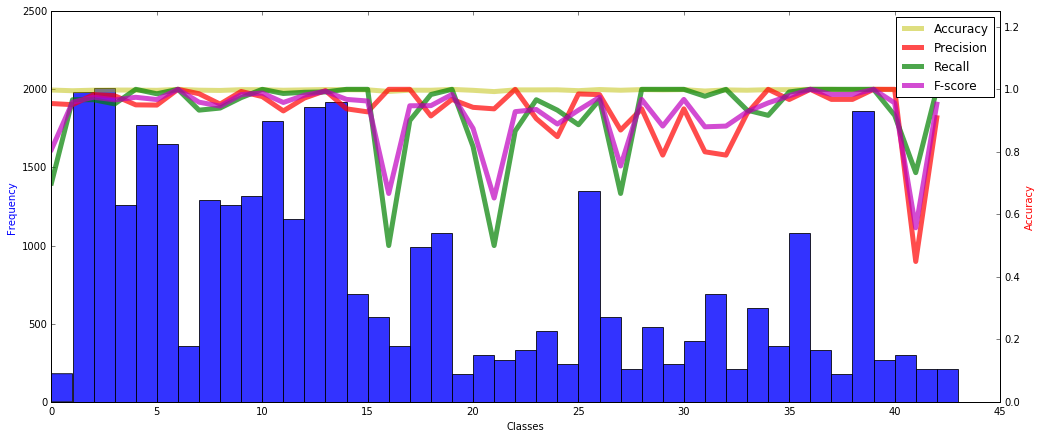

In [82]:

correctness   = (predictions_valid == y_valid)
classAccuracy = np.zeros((n_classes,1))
classPrecision = np.zeros((n_classes,1))
classRecall = np.zeros((n_classes,1))
classFscore = np.zeros((n_classes,1))
for sign in range(n_classes):
    #sign = 6
    idxDataset = (y_valid == sign) #Indices of signs of this type in the dataset
    numSign    = np.count_nonzero(idxDataset)   #Number  of signs of this type in the dataset

    idxDetected = (predictions_valid == sign) #Indcies of signs of this type detected
    numDetected = np.count_nonzero(idxDetected) #Number of signs of this type detected

    numTruePos  = np.count_nonzero(np.logical_and(idxDataset, idxDetected))
    classPrecision[sign] = numTruePos/numDetected
    classRecall[sign] = numTruePos/numSign

    
    signaccuracy = np.count_nonzero(idxDataset == idxDetected)/correctness.size
    #signcorrectness = correctness[idxDataset]
    #signaccuracy = np.count_nonzero(correctness)/correctness.size
    classAccuracy[sign] = signaccuracy

classFscore = 2/(1/classPrecision + 1/classRecall)    
    
#print(np.argwhere(idxDataset), numSign)
print(classPrecision[sign], classRecall[sign])



#print("Classes with accuracy less than 0.6:")    
#print(np.argwhere(classAccuracy<0.6)[:,0])



#print(x_train.shape)
#Deep dive into 16, 21 and 27    

#indPrediction = validation_predictions[y_valid==16]
#print(indPrediction)


# Look at the misclassified images in the validation set
idx = 27
#incorrect = np.logical_and((validation_predictions != idx), (y_valid==idx))
#sample = x_valid[incorrect]
#print(sample.shape)
#plt.imshow(sample[np.random.randint(0, sample.shape[0], size=1)[0], :,:,:])

# Look at the train set
#incorrect = x_train[(y_train==idx)]
#plt.imshow(incorrect[np.random.randint(0, incorrect.shape[0], size=1)[0], :,:,:])

#sample = x_train[y_train==16]
#plt.imshow(sample[3,:,:,:])
 
    
    
compFig, compax1 = plt.subplots(figsize=(17,7))
compax1.hist(y_train, bins=np.arange(y_train.min(), y_train.max()+2), alpha=0.8)
compax1.set_xlabel("Classes")
compax1.set_ylabel('Frequency', color='b')

compax2 = compax1.twinx()
compax2.plot(np.arange(n_classes), classAccuracy,  'y-', alpha=0.5, linewidth=5, label="Accuracy")
compax2.plot(np.arange(n_classes), classPrecision, 'r-', alpha=0.7, linewidth=5, label="Precision")
compax2.plot(np.arange(n_classes), classRecall,    'g-', alpha=0.7, linewidth=5, label="Recall")
compax2.plot(np.arange(n_classes), classFscore,    'm-', alpha=0.7, linewidth=5, label="F-score")
compax2.set_ylabel('Accuracy', color='r')
compax2.set_ylim([0,1.25])
plt.legend()
plt.show

#print(np.arange(0, 1, 10))

#imgpos = np.argwhere((y_valid==24))
#nimg = imgpos.size

#the24 = np.squeeze(x_valid[imgpos])
#print(the24.shape)

#nshow = np.random.randint(low=0, high=nimg, size=1)
#print(nimg)
#plt.imshow(the24[nshow[0], :,:,:])
#plt.show

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")